# Computer Vision and Deep Learning - Laboratory 3 

Starting from this session, we'll be diving into deep convolutional neural networks and we'll start using _tensorflow_ a popular machine learning library developed by Google.

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from google.colab.patches import cv2_imshow

In [ ]:
# download an image that we'll be using at this lab
!wget https://www.researchgate.net/profile/Paul-Rodriguez-5/publication/265988128/figure/fig1/AS:459614656438273@1486592081799/Input-test-images-a-Cameraman-grayscale-b-grayscale-Lena-and-c-color-Lena-All_Q640.jpg -O cameraman.jpg

--2022-01-05 11:16:06--  https://www.researchgate.net/profile/Paul-Rodriguez-5/publication/265988128/figure/fig1/AS:459614656438273@1486592081799/Input-test-images-a-Cameraman-grayscale-b-grayscale-Lena-and-c-color-Lena-All_Q640.jpg
Resolving www.researchgate.net (www.researchgate.net)... 104.17.33.105, 104.17.32.105, 2606:4700::6811:2169, ...
Connecting to www.researchgate.net (www.researchgate.net)|104.17.33.105|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2022-01-05 11:16:06 ERROR 403: Forbidden.



# Warm-up
 
 
Let's start by implementing the basic blocks of a convolutional neural network: the convolutional and the pooling operations. Perhaps this would be the last "low-level" implementation that you'll do for this laboratory.
 
## Convolutions
 
The convolutional layer is the main building block of a convolutional neural network. These layers contain a set of learnable filters, which will learn which features are relevant for the classification problem based on the training data.
During the forward pass, each filter (which __must__ have the same depth as the input volume) is slided over the spatial dimensions of the input volume and we compute an element-wise multiplication between the filter weights and the region of interest in the input volume that lies beneath the filter.
 
The hyperparameters of a convolutional layer are:
- the filter size F (usually this is an odd value);
- the padding amount which will be added to the input volume P;
- the stride S (or the step used when sliding across the input volume);
- the number of filters k; the depth of each filter must match the depth of the input volume;
 
Given an input volume of shape  ($H_i$, $W_i$, $D$), the convolutional layer will produce an output of shape ($H_o$, $W_o$, $k$), where:
 
\begin{equation}
W_o = \frac{W_i - F + 2P}{S} + 1
\end{equation}
 
\begin{equation}
H_o = \frac{H_i - F + 2P}{S} + 1
\end{equation}
 
<img src="https://lh6.googleusercontent.com/gZxwFH6mQ5tPjz6LzVbOaNeVuR1NC-BnuemIWO41qnn7r1PvP4qzwXRWC1OJgo2_PD08qaqJ2-VCF3q9laeK885IJwK-dHhpLDkvRZrx4vxrbLDTsKD2iZYM5SFRq4A6XTklk7_h"/>

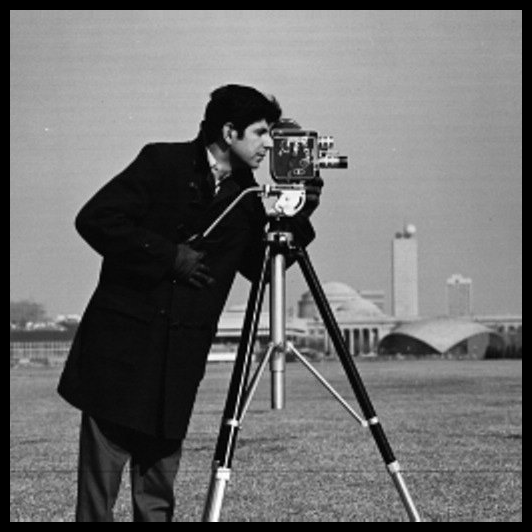

In [ ]:
def zero_pad(X, pad):
  """
  This function applies the zero padding operation on all the images in the array X
  :param X input array of images; this array has a of rank 4 (batch_size, height, width, channels)
  :param pad the amount of zeros to be added around around the spatial size of the images
  """
  # hint you might find the function numpy.pad useful for this purpose
  # keep in mind that you only need to pad the spatial dimensions (height and width)
  X = np.pad(X, ((0, 0),(pad, pad),(pad, pad),(0, 0)), mode='constant')
  return X

# load the image using Pillow
img = Image.open('/content/cameraman.jpg')
img = np.asarray(img)
img = np.stack([img], axis=2)
img = np.stack([img], axis=0)
returned_image = zero_pad(img, 10)[0, :, :, 0]
cv2_imshow(returned_image)

# TODO your code here 
# pad and display the cameraman.jpg image 
# (if you are using matplotlib to display the image, use cmap='gray' in the imshow function)

In [ ]:
def convolution(X, W, bias, pad, stride):
  """
  This function applied to convolution operation on the input X of shape (num_samples, iH, iW, iC)
  using the filters defined by the W (filter weights) and  (bias) parameters.

  :param X - input of shape (num_samples, iH, iW, iC)
  :param W - weights, numpy array of shape (fs, fs, iC, k), where fs is the filter size, 
    iC is the depth of the input volum and k is the number of filters applied on the image
  :param biases - numpy array of shape (1, 1, 1, iC)
  :param pad - hyperparameter, the amount of padding to be applied
  :param stride - hyperparameter, the stride of the convolution
  """

  # 0. compute the size of the output activation map and initialize it with zeros

  num_samples = X.shape[0]
  iW = X.shape[2]
  iH = X.shape[1]
  f = W.shape[0]
  
  # compute the output width (oW), height (oH) and number of channels (oC)
  oW = int((iW + pad * 2 - f) / stride) + 1
  oH = int((iH + pad * 2 - f) / stride) + 1
  oC = W.shape[3]
  # initialize the output activation map with zeros
  activation_map = np.zeros((num_samples, oH, oW, oC))
  # end TODO your code here

  # 1. pad the samples in the input 
  # TODO your code here, pad X using pad amount
  X_padded = zero_pad(X, pad)
  # end TODO your code here
  
  # go through each input sample
  for i in range(num_samples):                 
    # TODO: get the current sample from the input (use X_padded)
    X_i = X_padded[i]
    # end TODO your code here

    # loop over the spatial dimensions
    for y in range(oH):     
      # TODO your code here
      # compute the current ROI in the image on which the filter will be applied (y dimension)
      # tl_y - the y coordinate of the top left corner of the current region
      # br_y - the y coordinate of the bottom right corner of the current region
      tl_y = y * stride
      br_y = tl_y + f
      # end TODO your code here

      for x in range(oW):
        # TODO your code here       
        # compute the current ROI in the image on which the filter will be applied (x dimension)
        # tl_x - the x coordinate of the top left corner of the current region
        # br_x - the x coordinate of the bottom right corner of the current region
        tl_x = x * stride
        br_x = tl_x + f
        # end TODO your code here
        
        for c in range(oC):               
            # select the current ROI on which the filter will be applied
            roi = X_padded[i, tl_y: br_y, tl_x: br_x, :]
            w = W[:, :, :, c]
            b = bias[:, :, :, c]
           
            # TODO your code here
            # apply the filter with the weights w and bias b on the current image roi
            
            # A. compute the elemetwise product between roi and the weights of the filters (np.multiply)
            a = np.multiply(roi, w)
            # B. sum across all the elements of a
            a = np.sum(a)
            # C. add the bias term 
            a = np.add(a, b)
            
            # D. add the result in the appropriate position of the output activation map
            activation_map[i, y, x, c] = a
            # end TODO your code here
        assert(activation_map.shape == (num_samples, oH, oW, oC))
  return activation_map



np.random.seed(10)
# 100 samples of shape (13, 21, 4)
X = np.random.randn(100, 13, 21, 4)

# 8 filters (last dimension) of shape (3, 3)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)

am = convolution(X, W, b, pad=1, stride=2)
print("am's mean =\n", np.mean(am))
print("am[1, 2, 3] =\n", am[3,2,1])


am's mean =
 -0.4284130223223714
am[1, 2, 3] =
 [ 1.78081902 -6.51813947 -4.35815226 -2.91158344  1.84016713 -3.72264278
 -8.32761753 -3.22778695]


Expected output: 

am's mean =
 -0.42841306

am[1, 2, 3] =
 [ 1.780819  -6.5181394 -4.3581524 -2.9115834  1.8401672 -3.722643
 -8.327618  -3.227787 ]

Now let's analyse the effect of applying some well known filters used in image processing.
 
### Low pass filters
Low pass filters are used to keep the low frequency information within an, while reducing the high frequency information. These filters are the basis of image smoothing.
 
Two well known low pass filters are the _mean filter_ and the _Gaussian filter_.

In [ ]:
# load the image using Pillow
image = Image.open('/content/cameraman.jpg')
image = np.asarray(image)
image = np.expand_dims(image, axis=-1)

# X contains a single image sample
X = np.expand_dims(image, axis=0)

Text(0.5, 1.0, 'Gaussian filtered')

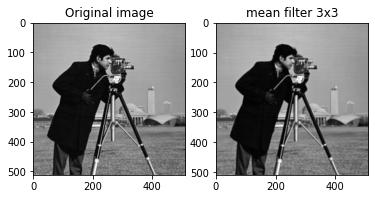

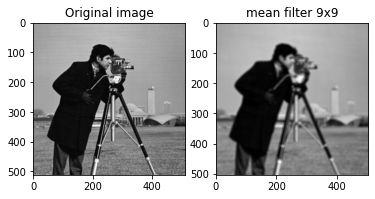

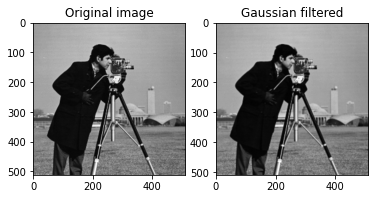

In [ ]:
############################################################
# MEAN FILTER
############################################################

bias = np.asarray([0])
bias = bias.reshape((1, 1, 1, 1))

mean_filter_3 = np.ones(shape=(3, 3, 1, 1), dtype=np.float32)
mean_filter_3 = mean_filter_3/9.0

mean_filter_9 = np.ones(shape=(9, 9, 1, 1), dtype=np.float32)
mean_filter_9 = mean_filter_9/81.0

mean_3x3 = convolution(X, mean_filter_3, bias, pad=0, stride=1)
mean_9x9 = convolution(X, mean_filter_9, bias, pad=0, stride=1)

plt.figure(0)
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(mean_3x3[0, :, :, 0], cmap='gray')
plt.title('mean filter 3x3')

plt.figure(2)
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(mean_9x9[0, :, :, 0], cmap='gray')
plt.title('mean filter 9x9')


############################################################
# GAUSSIAN FILTER
############################################################

gaussian_filter = np.asarray(
    [[1, 2, 1],
     [2, 4, 2],
     [1, 2, 1]],
     dtype=np.float32
)
gaussian_filter = gaussian_filter.reshape(3, 3, 1, 1)
gaussian_filter = gaussian_filter/16.0

gaussian_smoothed = convolution(X, gaussian_filter, bias, pad=0, stride=1)

plt.figure(3)
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(gaussian_smoothed[0,:,:,0], cmap='gray')
plt.title('Gaussian filtered')


Now load a color image and apply the mean filtering and Gaussian filtering on this color image.
Not much changes at the call of the convolution operation, you just need to "play" with the convolutional kernels configurations.

Text(0.5, 1.0, 'Gaussian filtered')

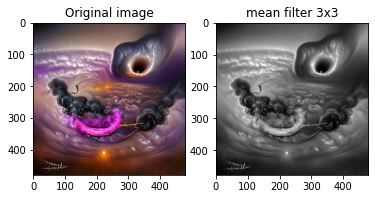

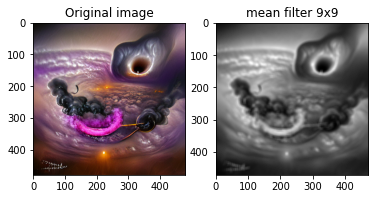

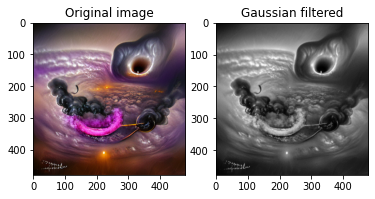

In [ ]:
# TODO your code here
image = Image.open('/content/progress.png')
image = np.asarray(image)
X = np.expand_dims(image, axis=0)

bias = np.asarray([0])
bias = bias.reshape((1, 1, 1, 1))

mean_filter_3 = np.ones(shape=(3, 3, 1, 1), dtype=np.float32)
mean_filter_3 = mean_filter_3/9.0

mean_filter_9 = np.ones(shape=(9, 9, 1, 1), dtype=np.float32)
mean_filter_9 = mean_filter_9/81.0

mean_3x3 = convolution(X, mean_filter_3, bias, pad=0, stride=1)
mean_9x9 = convolution(X, mean_filter_9, bias, pad=0, stride=1)

plt.figure(0)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(mean_3x3[0, :, :, 0], cmap='gray')
plt.title('mean filter 3x3')

plt.figure(2)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(mean_9x9[0, :, :, 0], cmap='gray')
plt.title('mean filter 9x9')

gaussian_filter = np.asarray(
    [[1, 2, 1],
     [2, 4, 2],
     [1, 2, 1]],
     dtype=np.float32
)
gaussian_filter = gaussian_filter.reshape(3, 3, 1, 1)
gaussian_filter = gaussian_filter/16.0

gaussian_smoothed = convolution(X, gaussian_filter, bias, pad=0, stride=1)

plt.figure(3)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(gaussian_smoothed[0,:,:,0], cmap='gray')
plt.title('Gaussian filtered')


### High pass filters 

On the other hand, high pass filters are used to highlight the high frequency information in an image (edges, abrupt changes in intensities).

One of the most commonly used high pass filters is the Sobel kernel (depicted below). These filters can be seen as discrete differentiation operators, and they compute an approximation of the gradient (on the horizontal or vertical direction) of the image intensity function.

<img src="https://i.ytimg.com/vi/W7OpxFbrD84/maxresdefault.jpg" width=300px/>

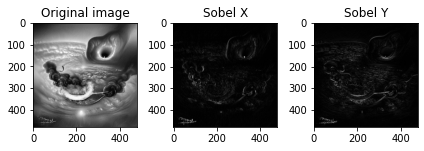

In [ ]:
sobel_horiz = np.asarray([[-1, 0, 1],
                          [-2, 0, 2], 
                          [-1, 0, 1]])

sobel_vert = sobel_horiz.T 

sobel_horiz = np.reshape(sobel_horiz, (3, 3, 1, 1))
sobel_vert = np.reshape(sobel_vert, (3, 3, 1, 1))

sobel_x = convolution(X, sobel_horiz, bias, 0, 1)
sobel_y = convolution(X, sobel_vert, bias, 0, 1)


plt.subplot(1, 3, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(sobel_x[0,:,:,0])/np.abs(np.max(sobel_x[0,:,:,0]))*255, cmap='gray')
plt.title('Sobel X')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(sobel_y[0,:,:,0])/np.abs(np.max(sobel_y[0,:,:,0]))*255, cmap='gray')
plt.title('Sobel Y')
plt.tight_layout()


## Pooling

The pooling layer is used to reduce the spatial dimension of the activation maps, and thus the computational burden. It has no learnable parameters and it operates individually across each input channel and resizes it spatially.

The two most common types of pooling are max pooling and average pooling.


The hyperparameters of a pooling layer are:
- the filter size F (usually this is an odd value);
- the stride S (or the step used when sliding across the input volume);

Given an input volume of shape  ($H_i$, $W_i$, $D$), the convolutional layer will produce an output of shape ($H_o$, $W_o$, $D$), where:

\begin{equation}
W_o = \frac{W_i - F}{S} + 1
\end{equation}

\begin{equation}
H_o = \frac{H_i - F}{S} + 1
\end{equation}

An illustration of the pooling operation is depicted in the image below:

![picture](https://www.researchgate.net/profile/Alla-Eddine-Guissous/publication/337336341/figure/fig15/AS:855841334898691@1581059883782/Example-for-the-max-pooling-and-the-average-pooling-with-a-filter-size-of-22-and-a.jpg)

[[[ 5.]
  [ 8.]]

 [[-1.]
  [ 7.]]]
[[[ 2.]
  [ 3.]]

 [[-4.]
  [ 4.]]]


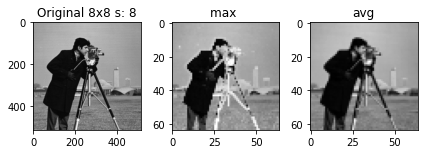

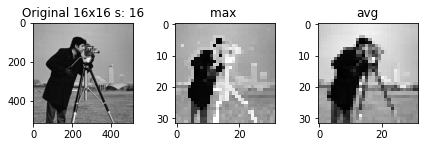

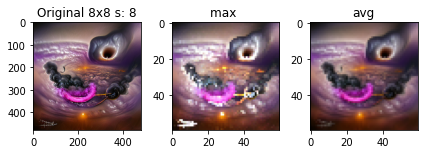

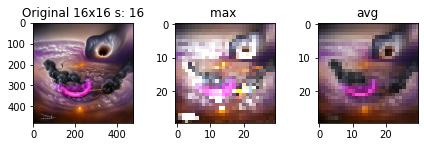

In [ ]:
def pooling(X, filter_size, stride, type):
  """
  Implements the pooling operation
  
  :param X - input volume of shape (num_samples, H, W, C)
  :param filter_size - the size of the pooling
  :param stride - the stride of the pooling operation
  :param type - can be 'max' or 'avg'; the type of the pooling operation to apply
  
  Returns the output of the pooling operation.
  """
  # TODO your code here implement the pooling operation
  # you can ispire yourself from the convolution implementation on how to organize your code
  pool = {
      "max": np.max,
      "avg": np.average
  }

  num_samples = X.shape[0]
  iW = X.shape[2]
  iH = X.shape[1]

  oW = int((iW - filter_size)/stride) + 1
  oH = int((iH - filter_size)/stride) + 1
  oC = X.shape[3]

  activation_map = np.zeros((num_samples, oH, oW, oC))
  for i in range(num_samples):
      for y in range(oH):
          tl_y = y*stride
          br_y = tl_y+filter_size
          for x in range(oW):
              tl_x = x*stride
              br_x = tl_x+filter_size
              for c in range(oC):
                  roi = X[i, tl_y: br_y, tl_x: br_x, c]
                  activation_map[i, y, x, c] = pool[type](roi)
  assert(activation_map.shape == (num_samples, oH, oW, oC))
  return activation_map


a = np.array([
    [2, 3, 2, 0],
    [5,-2, 2, 8],
    [-1, -6, 7, 3],
    [-4, -5, 4, 2]
])
a = np.stack([a])
a = np.stack([a], -1)
mx = pooling(a, 2, 2, "max")[0]
avg = pooling(a, 2, 2, "avg")[0]
print(mx)
print(avg)

# TODO your code here
# apply the pooling operation on a grayscale image and on a color image
# try different values for the stride and filter size. What do you observe?

gray_image = Image.open('/content/cameraman.jpg')
color_image = Image.open('/content/progress.png')

def gray_scale_pool(X, filter_size, stride, figure):
    image = np.asarray(gray_image)
    image = np.expand_dims(image, axis=-1)
    X = np.expand_dims(image, axis=0)
    mx = pooling(X, filter_size, stride, "max").astype(int)
    avg = pooling(X, filter_size, stride, "avg").astype(int)
    plt.figure(figure)
    plt.subplot(1, 3, 1)
    plt.imshow(gray_image, cmap='gray')
    plt.title(f"Original {filter_size}x{filter_size} s: {stride}")
    plt.subplot(1, 3, 2)
    plt.imshow(mx[0, :, :, 0], cmap='gray')
    plt.title(f"max ")
    plt.subplot(1, 3, 3)
    plt.imshow(avg[0, :, :, 0], cmap='gray')
    plt.title(f"avg")
    plt.tight_layout()

def color_pool(X, filter_size, stride, figure):
    image = np.asarray(gray_image)
    image = np.expand_dims(image, axis=-1)
    X = np.expand_dims(color_image, axis=0)
    mx = pooling(X, filter_size, stride, "max")[0].astype(int)
    avg = pooling(X, filter_size, stride, "avg")[0].astype(int)
    plt.figure(figure)
    plt.subplot(1, 3, 1)
    plt.imshow(color_image)
    plt.title(f"Original {filter_size}x{filter_size} s: {stride}")
    plt.subplot(1, 3, 2)
    plt.imshow(mx)
    plt.title(f"max ")
    plt.subplot(1, 3, 3)
    plt.imshow(avg)
    plt.title(f"avg")
    plt.tight_layout()

gray_scale_pool(X, 8, 8, 1)
gray_scale_pool(X, 16, 16, 2)
color_pool(X, 8, 8, 3)
color_pool(X, 16, 16, 4)

# Hello, _tensorflow_!

Follow [this tutorial](https://www.tensorflow.org/tutorials/images/cnn) to build your first convolutional neural network using a sequential model in a few lines of code.


In [ ]:
# Imports
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Fetching the data

In [ ]:
# load the data
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170508288/170498071 [==============================] - 2s 0us/step


### Verify the data

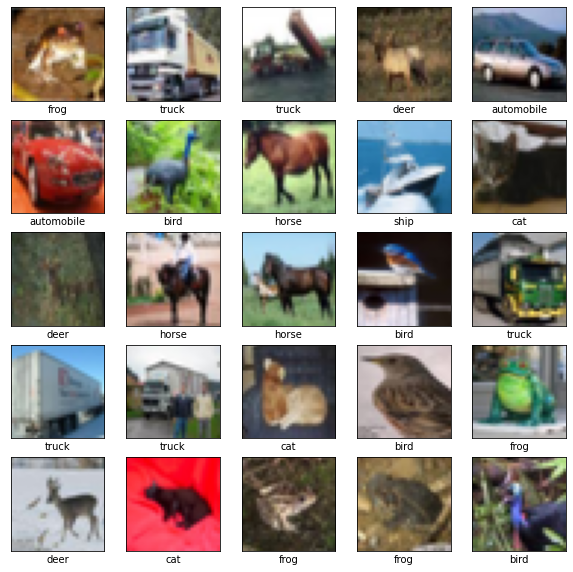

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

### Model training

In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 42s 8ms/step - loss: 1.5565 - accuracy: 0.4320 - val_loss: 1.2911 - val_accuracy: 0.5256
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1772 - accuracy: 0.5809 - val_loss: 1.1790 - val_accuracy: 0.5862
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0411 - accuracy: 0.6346 - val_loss: 1.1395 - val_accuracy: 0.6016
Epoch 4/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.9494 - accuracy: 0.6659 - val_loss: 0.9611 - val_accuracy: 0.6657
Epoch 5/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.8861 - accuracy: 0.6903 - val_loss: 0.9133 - val_accuracy: 0.6848
Epoch 6/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.8380 - accuracy: 0.7070 - val_loss: 0.8958 - val_accuracy: 0.6923
Epoch 7/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.7933 - accuracy: 0.7210 - val_loss: 0.8968 - val_ac

### Model evaluation

313/313 - 1s - loss: 0.8965 - accuracy: 0.6966
0.6966000199317932


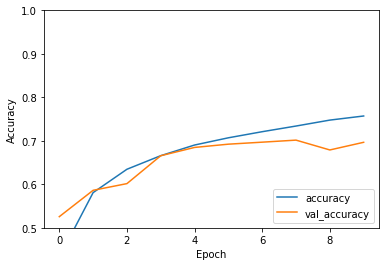

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

This was pretty easy!  In the next laboratory we'll look at a basic "recipe" on how we can effectively tune the hyperparameters of a network, but for now let's just get familiar with _tensorflow_ and see how we can modify some parameters of this vanilla network.

- First of all, move the model.summary() call at the end of your model creation (after the last dense layer) and analyse the number of parameters of each layer.
- [Serialize](https://www.tensorflow.org/guide/keras/save_and_serialize) your model after training.
- Change the initializers of the layers with ReLu activations to [He initializer](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal). Retrain and save the results.
- Add some [regularization](https://keras.io/api/layers/regularizers/) to your network. Retrain and save the results.
- Add a [dropout layer](https://keras.io/api/layers/regularization_layers/dropout/) after the layer with the highest number of parameters and retrain your network. Retrain and save the results.

Plot the learning curver for all teh training that you performed.
Create a table to compare the accuracy of your trained models.

| Colum1      | Column2 |
| ----------- | ----------- |
| Cell11      | Cell12      |
| Cell21      | Cell22      |

## Writing a custom layer
 
As you observed, when using _tensorflow_ you work at a high level of abstraction via layers. In other words, you don't need to get your hands dirty by manipulating variables, and usually you just stack several layers on top of each other to build your models.
 
_tensorflow_ provides by default many layers commonly used in machine learning, but it also provides you an easy way to write your custom layers based on your needs. These layers can be written  from scratch or as the composition of several existing layers.
 
To implement a custom layer you just need to extend from _tf.keras.Layer_ and implement the following methods:
- \_\_init__(), where you can do all input-independent initialization;
- build(), where you know the shapes of the input tensors and can do the rest of the initialization; you can as well create all the variables in the constructor, but  the advantage of creating them in build is that it enables late variable creation based on the shape of the inputs the layer will operate on;
- call(), where you do the forward computation of that layer
 
In the last part of the laboratory you will implement a custom image augmentation layer, namely [_cutout_](https://arxiv.org/pdf/1708.04552.pdf). 
 
Cutout is a very simple augmentation that can boost your test accuracy with more than 1%. 
 
"_Cutout is a simple regularization technique for convolutional neural networks that involves removing contiguous
sections of input images, effectively augmenting the dataset
with partially occluded versions of existing samples. This
technique can be interpreted as an extension of dropout in
input space, but with a spatial prior applied, much in the
same way that CNNs apply a spatial prior to achieve improved performance over feed-forward networks on image
data._"
 
## Implementation details (text from the original cutout paper)
"_To implement cutout, we simply apply a fixed-size zeromask to a random location of each input image during each
epoch of training._
 
<img src="https://raw.githubusercontent.com/xkumiyu/numpy-data-augmentation/master/data/output/cutout.jpg" width=200px/>
 
_When cutout is applied to an image, we randomly select a pixel coordinate within the image
as a center point and then place the cutout mask around that
location. 
This method allows for the possibility that not all
parts of the cutout mask are contained within the image. Interestingly, we found that allowing portions of the patches
to lay outside the borders of the image (rather than constraining the entire patch to be within the image) was critical to achieving good performance._"
 
You can follow [this](https://www.tensorflow.org/tutorials/images/data_augmentation#custom_data_augmentation) tutorial to see how you can write a custom data augmentation layer.
 

In [ ]:
# Imports
from tensorflow.keras import layers

### Implementing the custom layer

In [ ]:
def build_cutout(x, size):
    cut = x
    shape = x.get_shape()
    mask = np.ones(shape)

    tl_x = max(0, min(np.random.randint(0, shape[0]) - size, shape[0]))
    tl_y = max(0, min(np.random.randint(0, shape[1]) - size, shape[1]))
    br_x = max(0, min(np.random.randint(0, shape[0]) + size, shape[0]))
    br_y = max(0, min(np.random.randint(0, shape[1]) + size, shape[1]))

    mask[tl_x:br_x, tl_y:br_y, :] = np.zeros((br_x-tl_x, br_y-tl_y, shape[2]))
    cut = tf.where(tf.convert_to_tensor(mask, dtype=tf.bool), cut, 0)

    return cut

In [ ]:
class CutoutImage(layers.Layer):
  def __init__(self, size, **kwargs):
    super().__init__(**kwargs)
    self.size = size
  def call(self, x, training=None):
    if not training:
        return x
    return tf.map_fn(lambda elem: build_cutout(elem, self.size), x)

In [ ]:
initializer = tf.keras.initializers.HeNormal()
regularizer = tf.keras.regularizers.l1_l2(l1=1e-6, l2=2e-4)

model = models.Sequential()
model.add(CutoutImage(9))
model.add(layers.Conv2D(32, (3, 3),
                        kernel_initializer=initializer,
                        kernel_regularizer=regularizer,
                        bias_regularizer=regularizer,
                        activity_regularizer=regularizer,
                        padding="same", activation='relu', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3),
                        kernel_initializer=initializer,
                        kernel_regularizer=regularizer,
                        bias_regularizer=regularizer,
                        activity_regularizer=regularizer,
                        padding="same", activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3),
                        kernel_initializer=initializer,
                        kernel_regularizer=regularizer,
                        bias_regularizer=regularizer,
                        activity_regularizer=regularizer,
                        padding="same", activation='relu'))
model.add(layers.Conv2D(32, (3, 3),
                        kernel_initializer=initializer,
                        kernel_regularizer=regularizer,
                        bias_regularizer=regularizer,
                        activity_regularizer=regularizer,
                        padding="same", activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3),
                        kernel_initializer=initializer,
                        kernel_regularizer=regularizer,
                        bias_regularizer=regularizer,
                        activity_regularizer=regularizer,
                        padding="same", activation='relu'))
model.add(layers.Conv2D(64, (3, 3),
                        kernel_initializer=initializer,
                        kernel_regularizer=regularizer,
                        bias_regularizer=regularizer,
                        activity_regularizer=regularizer,
                        padding="same", activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64,
                        kernel_initializer=initializer,
                        kernel_regularizer=regularizer,
                        bias_regularizer=regularizer,
                        activity_regularizer=regularizer,
                        activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(10))

model.build(input_shape=(None, 32,32,3))
#model.summary()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=3e-4,
                                                              decay_steps=100000,
                                                              decay_rate=0.96)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history =  model.fit(train_images, train_labels, epochs=10, batch_size=32,
                      validation_data=(test_images, test_labels)
                      )

Epoch 1/10
1563/1563 [==============================] - 70s 37ms/step - loss: 2.0713 - accuracy: 0.3669 - val_loss: 1.4944 - val_accuracy: 0.5315
Epoch 2/10
1563/1563 [==============================] - 57s 36ms/step - loss: 1.5299 - accuracy: 0.5280 - val_loss: 1.4065 - val_accuracy: 0.5554
Epoch 3/10
1563/1563 [==============================] - 57s 36ms/step - loss: 1.3553 - accuracy: 0.5913 - val_loss: 1.2012 - val_accuracy: 0.6436
Epoch 4/10
1563/1563 [==============================] - 57s 36ms/step - loss: 1.2530 - accuracy: 0.6334 - val_loss: 1.1700 - val_accuracy: 0.6439
Epoch 5/10
1563/1563 [==============================] - 56s 36ms/step - loss: 1.1786 - accuracy: 0.6592 - val_loss: 1.0565 - val_accuracy: 0.6968
Epoch 6/10
1563/1563 [==============================] - 57s 36ms/step - loss: 1.1101 - accuracy: 0.6864 - val_loss: 1.0225 - val_accuracy: 0.7096
Epoch 7/10
1563/1563 [==============================] - 57s 37ms/step - loss: 1.0566 - accuracy: 0.7084 - val_loss: 0.9933 -

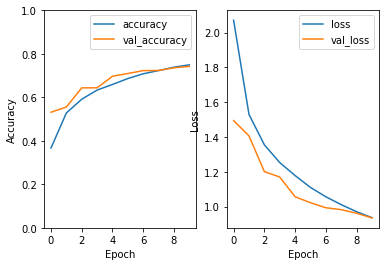

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
plt.legend(loc='upper right')

Please take some time to complete this feedback [from](https://docs.google.com/forms/d/1MezmHGuHUh1B40gm2HZMR_HdFaXZrGne7QyBQJPKGmc/edit). Thanks!